In [2]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import io
import time
import shlex
from importlib import reload
from collections import defaultdict
from math import ceil, floor

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from scipy.misc import imresize, imsave

import numpy as np
import tensorflow as tf

import graph_manager
import tf_inputs
import tf_utils
import tfrecords_utils
import viz

import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)

## Data Format

---

We create TFRecords that contains the ground-truth as

  * `im_id`, the identifier used to resolve the filepath
  * `num_boxes`, the number of valid boxes in the image
  * `bounding boxes`, the list of bounding boxes in the image. Empty boxes are represented as [1, 1, 0, 0]. 
    Padded to the shape `(max_number_bounding_boxes, 4)`
  * `classes`, the list of classes for each box. -1 if empty box.

Then the TF input pipeline will take care of computing the missing information (e.g. compute group ground-truth on-the-fly)

In [5]:
def write_data_to_tfrecords(image_ids, image_annotations, output_file, pad=None, split=None):
    """Write the TFRecords
    
    Args:
        image_ids: List of image_ids
        image_annotations: Triples of list, each with the same size as image_ids
        output_file: output path for the TFRecords
        pad: If given, pad to the maximum number of bounding boxes
        split: Restrict the image ids to use
    """
    feature_keys = ['im_id', 'num_boxes', 'bounding_boxes', 'classes']
    num_examples = 0
    with tf.python_io.TFRecordWriter(output_file) as writer:
        for i, im_id in enumerate(image_ids):
            print('\rExample: %d/%d' % (i + 1, len(image_ids)), end='')
            if split is not None and im_id not in split:
                continue
            
            num_boxes = image_annotations[0][i]
            bounding_boxes = image_annotations[1][i]
            classes = image_annotations[2][i]
            
            if pad is not None:
                if bounding_boxes.shape[0] == 0:
                    bounding_boxes = np.tile(np.array([[1., 1., 0., 0.]]), (pad, 1))
                    classes = - np.ones((pad,))
                else:
                    bounding_boxes = np.pad(bounding_boxes - np.array([1., 1., 0., 0.]),
                                            ((0, pad - num_boxes), (0, 0)), 
                                            'constant') + np.array([1., 1., 0., 0.])
                    classes = np.pad(classes,((0, pad - num_boxes)), 'constant', constant_values=-1)
            feature = tfrecords_utils.write_tfrecords([
                ('im_id', int(im_id)), 
                ('num_boxes', int(num_boxes)),
                ('bounding_boxes', bounding_boxes.astype(np.float32)),
                ('classes', classes.astype(np.int32)),
            ])
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            serialized = example.SerializeToString()
            writer.write(serialized)
            num_examples += 1
    print()
    return num_examples, feature_keys

In [3]:
def oneshot_dataset(path_to_tfrecords, _parse_function, shuffle=100):
    """Create a small dataset for testing purposes"""
    data = tf.data.TFRecordDataset(path_to_tfrecords)
    data = data.shuffle(shuffle)
    data = data.map(_parse_function)
    iterator = data.make_one_shot_iterator()
    in_ = iterator.get_next()
    return in_

## VEDAI

---

1268 images, 1024x1024pixels, 3 objects per image on average [[link]](https://downloads.greyc.fr/vedai/)

### Load the Data

In [91]:
# classes
vedai_classes = {1: 'car', 2: 'truck', 23: 'ship', 4: 'tractor', 5: 'camping car', 9: 'van', 
                 10: 'others', 11: 'pick-up', 31: 'plane'}
# alphabetical sort
keys = list(vedai_classes.keys())
sorted_keys = sorted(range(len(keys)), key=lambda x: vedai_classes[keys[x]])
index = [0] * len(keys)
for i, pos in enumerate(sorted_keys):
    index[pos] = i
vedai_classes_index = {key: ind for key, ind in zip(keys, index)}
vedai_classes = [vedai_classes[keys[x]] for x in sorted_keys]
print('sorted classes', vedai_classes)
print('sorted index', vedai_classes_index)

sorted classes ['camping car', 'car', 'others', 'pick-up', 'plane', 'ship', 'tractor', 'truck', 'van']
sorted index {1: 1, 2: 7, 4: 6, 5: 0, 23: 5, 9: 8, 10: 2, 11: 3, 31: 4}


In [92]:
def load_vedai(image_ids, annotation_files, image_size=1024):
    """Load the vedai dataset
    
    Args:
        image_ids: List of image ids to load
        annotation_files: A dictionnary that maps image_id to the corresponding annotation file path (
            or empty entry if the image is empty)
        image_size: Used to normaize the bounding box coordinates to [0, 1]
    
    Outputs:
        max_num_bbs: The maximum number of bounding boxes in the dataset
        image_annotations: A triple of lists:
            - num_boxes: The number of valid bounding boxes for each image
            - bounding boxes: The bounding boxes coordinates (max_num_bbs, 4) for each image
            - classes: The class information (max_num_bbs,) for each image
    """
    # Load annotations
    image_annotations = [[], [], []]
    max_num_bbs = 0
    
    print('Load annotations:')
    for i, key in enumerate(image_ids):
        print('\r  %d/%d' % (i  + 1, len(image_ids,)), end='')
        # Empty images
        if key not in annotation_files:
            image_annotations[0].append(0)
            image_annotations[1].append(np.array([]))
            image_annotations[2].append(np.array([]))
        # Load annotation
        else:
            file = annotation_files[key]
            with open(file, 'r') as f:
                bbs = []
                classes = []
                for line in f.read().splitlines():
                    # Box coordinates
                    aux = line.split()
                    if len(aux) < 14:
                        continue
                    xs = list(map(float, aux[6:10]))
                    ys = list(map(float, aux[10:14]))
                    bb = np.array(np.ceil([np.amin(xs), np.amin(ys), np.amax(xs), np.amax(ys)])) / image_size
                    bb = np.clip(bb, 0., 1.)
                    bbs.append(bb) 
                    # Class information (map to `others` if unknown number)
                    try:
                        cl = vedai_classes_index[int(aux[3])]
                    except KeyError:
                        cl = vedai_classes_index[10]
                    classes.append(cl)
                # Add to `image_annotations`
                bbs = np.array(bbs, dtype=np.float32)
                max_num_bbs = max(max_num_bbs, bbs.shape[0])
                classes = np.array(classes, dtype=np.int32)
                image_annotations[0].append(bbs.shape[0])
                image_annotations[1].append(bbs)
                image_annotations[2].append(classes)
    print()
    return (max_num_bbs, image_annotations)

In [123]:
%%time
vedai_image_folder = '/home/aroyer/Datasets/VEDAI/Vehicules1024/'
image_files = {int(x.rsplit('_', 1)[0]): os.path.join(vedai_image_folder, x) 
                for x in os.listdir(vedai_image_folder) if x.endswith('_co.png')}
vedai_image_ids = list(image_files.keys())

annotation_path = '/home/aroyer/Datasets/VEDAI/Annotations1024/'
annotation_files = { int(x.rsplit('.', 1)[0]) : os.path.join(annotation_path, x)
                    for x in os.listdir(annotation_path) if x.endswith('txt') and x.startswith('0')}
(vedai_max_num_bbs, vedai_image_annotations) = load_vedai(vedai_image_ids, annotation_files)

print()
print('Loaded %d  samples' % (len(vedai_image_ids)))
print('%d max num bbs' % vedai_max_num_bbs)
print(np.mean(vedai_image_annotations[0]), 'average num bbs')
print()

Load annotations:
  1268/1268

Loaded 1268  samples
19 max num bbs
2.96293375394 average num bbs

CPU times: user 504 ms, sys: 212 ms, total: 716 ms
Wall time: 583 ms


### Write to TFRecords

In [94]:
with open('Data/vedai_split_train.txt', 'r') as f:
    vedai_train_split = list(map(int, f.readlines()))
    
with open('Data/vedai_split_test.txt', 'r') as f:
    vedai_test_split = list(map(int, f.readlines()))

In [95]:
%%time
path_to_train = 'Data/vedai_train'
num_vedai_train_samples, feature_keys = write_data_to_tfrecords(
    vedai_image_ids, vedai_image_annotations, path_to_train, pad=vedai_max_num_bbs, split=vedai_train_split)
print('Wrote', num_vedai_train_samples, 'training examples')
print()

path_to_test = 'Data/vedai_test'
num_vedai_test_samples, _ = write_data_to_tfrecords(
    vedai_image_ids, vedai_image_annotations, path_to_test, pad=vedai_max_num_bbs, split=vedai_test_split)
print('Wrote', num_vedai_test_samples, 'test examples')
print()

Example: 1268/1268
Wrote 1000 training examples

Example: 1268/1268
Wrote 268 test examples

CPU times: user 676 ms, sys: 216 ms, total: 892 ms
Wall time: 711 ms


In [96]:
with open('Data/metadata_vedai.txt', 'w') as f:
    f.write('train_tfrecords\t%s\n' % path_to_train)
    f.write('train_max_num_bbs\t%s\n' % vedai_max_num_bbs)
    f.write('train_num_samples\t%s\n' % num_vedai_train_samples)
    f.write('test_tfrecords\t%s\n' % path_to_test)
    f.write('test_max_num_bbs\t%s\n' % vedai_max_num_bbs)
    f.write('test_num_samples\t%s\n' % num_vedai_test_samples)
    f.write('data_classes\t%s\n' % ','.join(vedai_classes))
    f.write('feature_keys\t%s\n' % ','.join(feature_keys))
    f.write('image_folder\t%s\n' % vedai_image_folder)

### Test the input pipeline  + on-the-fly groups


In-graph inputs:
    group_flags: shape=[None, 4, 4, 1, 1], dtype=<dtype: 'float32'>
    obj_i_mask_bbs: shape=[None, 4, 4, 1, 19], dtype=<dtype: 'float32'>
    is_flipped: shape=[None], dtype=<dtype: 'float32'>
    group_bounding_boxes_per_cell: shape=[None, 4, 4, 1, 4], dtype=<dtype: 'float32'>
    num_boxes: shape=[None], dtype=<dtype: 'int32'>
    class_labels: shape=[None, 19, 9], dtype=<dtype: 'int32'>
    image: shape=[None, 1024, 1024, 3], dtype=<dtype: 'float32'>
    bounding_boxes: shape=[None, 19, 4], dtype=<dtype: 'float32'>
    group_class_labels: shape=[None, 4, 4, 1, 9], dtype=<dtype: 'int32'>
    im_id: shape=[None], dtype=<dtype: 'int32'>
    num_group_boxes: shape=[None], dtype=<dtype: 'int32'>

Sample:
    im_id: 104
    grid size [4 4]
    3 bbs
    3 bbs after grouping
    Classes: ship, car, car
    Group classes: car, car, ship


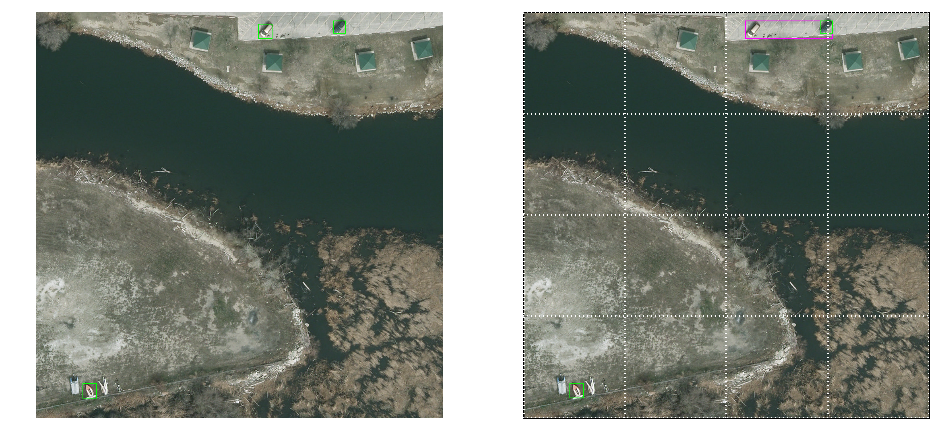

In [201]:
with tf.Graph().as_default():
    mode = 'test'
    metadata = graph_manager.load_metadata('Data/metadata_vedai.txt')  
    image_size = 1024
    
    num_cells = np.array([4, 4])
    grid_offsets = graph_manager.precompute_grid_offsets(num_cells)
    
    print('\n\033[44mIn-graph inputs:\033[0m')
    inputs = tf_inputs.get_tf_dataset(metadata['%s_tfrecords' % mode],
                                      metadata['feature_keys'],
                                      metadata['%s_max_num_bbs' % mode],
                                      len(metadata['data_classes']),
                                      with_classes=True,
                                      with_groups=True,
                                      grid_offsets=grid_offsets,
                                      data_augmentation_threshold=1.,
                                      image_folder=metadata['image_folder'],
                                      batch_size=1,
                                      image_size=image_size,
                                      shuffle_buffer=1000,
                                      verbose=True)[0]
    inputs = {k: v for k, v in inputs.items() if k != 'batch_size'}

    with tf.Session() as sess:
        inputs_ = sess.run(inputs)
        # Bounding boxes (Green)
        img = np.copy(inputs_['image'][0])
        for bb in inputs_['bounding_boxes'][0]:
            viz.draw_bounding_boxes_numpy(img, bb)
        # On-the-fly group bounding boxes (Magenta)
        group_img = np.copy(inputs_['image'][0])
        group_bbs = np.reshape(inputs_['group_bounding_boxes_per_cell'][0], (-1, 4))
        group_flags = np.reshape(inputs_['group_flags'][0], (-1))
        for bb, flag in zip(group_bbs, group_flags):
            viz.draw_bounding_boxes_numpy(group_img, bb, color=(1., 0., 1.) if flag else (0., 1., 0.))
            
        # Print
        print('\n\033[44mSample:\033[0m')
        print('    im_id:', inputs_['im_id'][0])
        print('    grid size', num_cells)
        print('   ', inputs_['num_boxes'][0], 'bbs')
        print('   ', inputs_['num_group_boxes'][0], 'bbs after grouping')
        classes = np.where(inputs_['class_labels'][0] > 0)[-1]
        print('    Classes:', ', '.join(metadata['data_classes'][index] for index in classes))
        group_classes = np.where(inputs_['group_class_labels'][0] > 0)[-1]
        print('    Group classes:', ', '.join(metadata['data_classes'][index] 
                                              for index in group_classes[:inputs_['num_group_boxes'][0]]))
        # Plot
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        ax1.imshow(img)        
        ax1.set_axis_off()
        ax2.imshow(group_img)        
        ax2.set_xticks(np.linspace(0, image_size, num_cells[0] + 1))
        ax2.set_yticks(np.linspace(0, image_size, num_cells[1] + 1))        
        ax2.tick_params(labelbottom='off', labelleft='off') 
        ax2.grid(color='white', linewidth=2)
        plt.show()

## SDD

--- 


60 videos, at most 1024x1024pixels, 12 objects per image on average [[link]](http://cvgl.stanford.edu/projects/uav_data/)

### Load images and annotations from videos

In [113]:
import cv2
sdd_classes_index = {'Biker': 0, 'Bus': 1, 'Car': 2, 'Cart': 3, 'Pedestrian': 4, 'Skater': 5}
sdd_classes = sorted(sdd_classes_index.keys())

def get_annotations(data_dir, setting, video, step=1):
    """Load annotation
    
    Args:
        data_dir: Base data directory
        setting: name of the setting, e.g. bookstore
        video: number of the video to load
        step: Only load annotations for every %step frame
        
    Returns:
        a dictionnary mapping a frame id to a bounding box, a bool whether the annotation is occluded 
        or not ("hard") and its class
    """
    global sdd_classes_index
    labels = os.path.join(data_dir, 'annotations', setting, 'video%d' % video, 'annotations.txt')
    annotations = defaultdict(lambda: [])
    with open(labels, 'r') as f:
        for line in f.read().splitlines():
            aux = shlex.split(line)
            frame = int(aux[5])
            if not frame % step == 0:
                continue
            bbox = map(int, aux[1:5])
            cl = sdd_classes_index[aux[9]]
            if not int(aux[6]) and not int(aux[7]): # exclude out of view and interpolated annots
                annotations[frame].append(list(bbox) + [cl])
    return annotations  


def load_sdd(data_dir, setting, video, index, image_ids, image_annotations,
             output_dir, image_size=1024, step=40):
    """Load and format SDD annotation for a given video
    
    Args:
        data_dir: Base data directory
        setting: name of the setting, e.g. bookstore
        video: number of the video to load
        index: Index of the video in the dataset, used to attribute a unique image id
        image_ids: List to accumulate image ids of the samples
        image_annotations: Triple of lists (num_boxes, bounding_boxes, classes) to accumulate the 
            annotations of the samples
        output_dir: Save the frame image in the given directory with the corresponding id
        image_size: used to resize and save the image
        step: Only load annotations for every %step frame
    
    """
    # Read the annotation
    annotations = get_annotations(data_dir, setting, video_id, step=step)
    # Open the video
    video_path = os.path.join(data_dir, 'videos', setting, 'video%d' % video, 'video.mov')
    cap = cv2.VideoCapture(video_path)
    cap.open(video_path)
    num_frame = 0
    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if  not ret: break
            if num_frame % step == 0:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                # image id: video index and frame index
                im_id = '%02d%06d' % (index, num_frame)
                image_ids.append(int(im_id))
                # pad and save image
                im_path = os.path.join(output_dir, '%s.jpeg' % im_id)
                height, width = frame.shape[:2]
                size = max(height, width)
                pad_x, pad_y = size - height, size - width
                pads = ((floor(pad_x / 2), ceil(pad_x / 2)), 
                        (floor(pad_y / 2), ceil(pad_y / 2)),
                        (0, 0))
                frame = np.pad(frame, pads, 'constant')
                frame = imresize(frame, (image_size, image_size))
                cv2.imwrite(im_path, frame)
                # Save annotations
                num_boxes = len(annotations[num_frame])
                image_annotations[0].append(num_boxes)
                if num_boxes > 0:
                    boxes = np.stack([bbox[:4] for bbox in annotations[num_frame]], axis=0).astype(np.float32)
                    boxes += np.array([pads[1][0], pads[0][0], pads[1][0], pads[0][0]], dtype=np.float32)
                    boxes /= float(size)
                    classes = np.stack([bbox[-1] for bbox in annotations[num_frame]], axis=0)
                else:
                    boxes = np.array(())
                    classes = np.array(())
                image_annotations[1].append(boxes)
                image_annotations[2].append(classes)
            num_frame += 1            
    except KeyboardInterrupt:
        print('Interrupted at frame', num_frame)
    finally:
        cap.release()

In [114]:
%%time
data_dir = '/fs3/group/chlgrp/datasets/stanford_campus_dataset/'
output_dir = '/home/aroyer/Datasets/sdd_images'
step = 40

stanford_image_ids = []
stanford_image_annotations = [[], [], []]

index = 1
for i, setting in enumerate(
    ['bookstore', 'coupa', 'deathCircle', 'gates', 'hyang', 'little', 'nexus', 'quad']):
    dir = os.path.join(data_dir, 'videos', setting)
    for video in sorted(os.listdir(dir)):
        video_id = int(video[5:])
        print('Loading...', video_id, setting)
        load_sdd(data_dir, setting, video_id, index, 
                 stanford_image_ids, stanford_image_annotations, 
                 output_dir, step=step)
        index += 1

Loading... 0 bookstore
Loading... 1 bookstore
Loading... 2 bookstore
Loading... 3 bookstore
Loading... 4 bookstore
Loading... 5 bookstore
Loading... 6 bookstore
Loading... 0 coupa
Loading... 1 coupa
Loading... 2 coupa
Loading... 3 coupa
Loading... 0 deathCircle
Loading... 1 deathCircle
Loading... 2 deathCircle
Loading... 3 deathCircle
Loading... 4 deathCircle
Loading... 0 gates
Loading... 1 gates
Loading... 2 gates
Loading... 3 gates
Loading... 4 gates
Loading... 5 gates
Loading... 6 gates
Loading... 7 gates
Loading... 8 gates
Loading... 0 hyang
Loading... 1 hyang
Loading... 10 hyang
Loading... 11 hyang
Loading... 12 hyang
Loading... 13 hyang
Loading... 14 hyang
Loading... 2 hyang
Loading... 3 hyang
Loading... 4 hyang
Loading... 5 hyang
Loading... 6 hyang
Loading... 7 hyang
Loading... 8 hyang
Loading... 9 hyang
Loading... 0 little
Loading... 1 little
Loading... 2 little
Loading... 3 little
Loading... 0 nexus
Loading... 1 nexus
Loading... 10 nexus
Loading... 11 nexus
Loading... 2 nexus


In [121]:
stanford_max_num_bbs = max(stanford_image_annotations[0])
print('Loaded', len(stanford_image_ids), 'samples')
print(stanford_max_num_bbs, 'max num bbs')
print(np.mean(stanford_image_annotations[0]), 'average num bbs')

Loaded 13095 samples
100 max num bbs
12.0714012982 average num bbs


### Write to TFRecords

In [117]:
with open('Data/sdd_split_train.txt', 'r') as f:
    stanford_train_split = list(map(int, f.readlines()))
    
with open('Data/sdd_split_test.txt', 'r') as f:
    stanford_test_split = list(map(int, f.readlines()))

In [119]:
%%time
path_to_train = 'Data/sdd_train'
num_stanford_train_samples, feature_keys = write_data_to_tfrecords(
    stanford_image_ids, stanford_image_annotations, path_to_train, 
    pad=stanford_max_num_bbs, split=stanford_train_split)
print('Wrote', num_stanford_train_samples, 'training examples')
print()

path_to_test = 'Data/sdd_test'
num_stanford_test_samples, _ = write_data_to_tfrecords(
    stanford_image_ids, stanford_image_annotations, path_to_test,
    pad=stanford_max_num_bbs, split=stanford_test_split)
print('Wrote', num_stanford_test_samples, 'test examples')
print()

Example: 13095/13095
Wrote 10476 training examples

Example: 13095/13095
Wrote 2619 test examples

CPU times: user 10.7 s, sys: 2.45 s, total: 13.1 s
Wall time: 11 s


In [120]:
with open('Data/metadata_sdd.txt', 'w') as f:
    f.write('train_tfrecords\t%s\n' % path_to_train)
    f.write('train_max_num_bbs\t%s\n' % stanford_max_num_bbs)
    f.write('train_num_samples\t%s\n' % num_stanford_train_samples)
    f.write('test_tfrecords\t%s\n' % path_to_test)
    f.write('test_max_num_bbs\t%s\n' % stanford_max_num_bbs)
    f.write('test_num_samples\t%s\n' % num_stanford_test_samples)
    f.write('data_classes\t%s\n' % ','.join(sdd_classes))
    f.write('feature_keys\t%s\n' % ','.join(feature_keys))
    f.write('image_folder\t%s\n' % output_dir)

### Test the input pipeline + on-the-fly groups


In-graph inputs:
    is_flipped: shape=[None], dtype=<dtype: 'float32'>
    num_boxes: shape=[None], dtype=<dtype: 'int32'>
    im_id: shape=[None], dtype=<dtype: 'int32'>
    bounding_boxes: shape=[None, 100, 4], dtype=<dtype: 'float32'>
    image: shape=[None, 1024, 1024, 3], dtype=<dtype: 'float32'>
    group_bounding_boxes_per_cell: shape=[None, 8, 8, 1, 4], dtype=<dtype: 'float32'>
    class_labels: shape=[None, 100, 6], dtype=<dtype: 'int32'>
    num_group_boxes: shape=[None], dtype=<dtype: 'int32'>
    obj_i_mask_bbs: shape=[None, 8, 8, 1, 100], dtype=<dtype: 'float32'>
    group_class_labels: shape=[None, 8, 8, 1, 6], dtype=<dtype: 'int32'>
    group_flags: shape=[None, 8, 8, 1, 1], dtype=<dtype: 'float32'>

Sample:
    im_id: 1000160
    grid size [8 8]
    16 bbs
    12 bbs after grouping
    Classes: Pedestrian, Pedestrian, Pedestrian, Pedestrian, Pedestrian, Pedestrian, Biker, Biker, Pedestrian, Pedestrian, Pedestrian, Pedestrian, Biker, Pedestrian, Pedestrian, Pedestrian


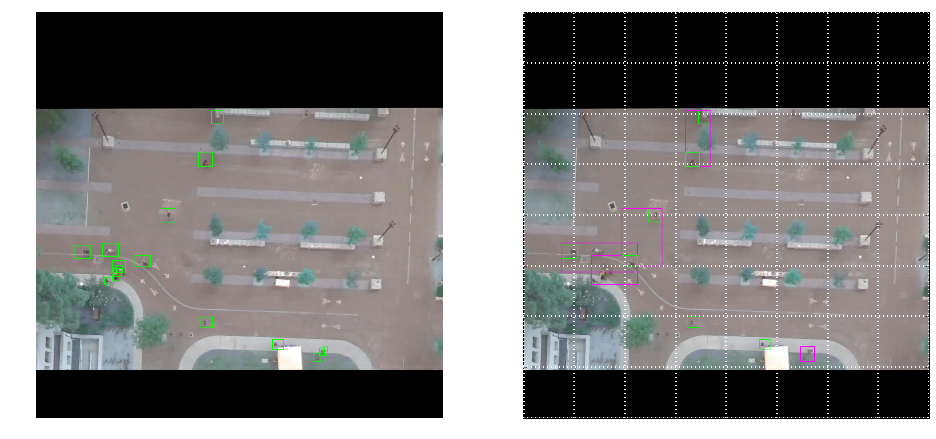

In [6]:
with tf.Graph().as_default():
    mode = 'test'
    metadata = graph_manager.load_metadata('Data/metadata_sdd.txt')  
    image_size = 1024
    
    num_cells = np.array([8, 8])
    grid_offsets = graph_manager.precompute_grid_offsets(num_cells)
    
    print('\n\033[44mIn-graph inputs:\033[0m')
    inputs = tf_inputs.get_tf_dataset(metadata['%s_tfrecords' % mode],
                                      metadata['feature_keys'],
                                      metadata['%s_max_num_bbs' % mode],
                                      len(metadata['data_classes']),
                                      with_classes=True,
                                      with_groups=True,
                                      grid_offsets=grid_offsets,
                                      data_augmentation_threshold=1.,
                                      image_folder=metadata['image_folder'],
                                      batch_size=1,
                                      image_size=image_size,
                                      shuffle_buffer=1,
                                      verbose=True)[0]
    inputs = {k: v for k, v in inputs.items() if k != 'batch_size'}

    with tf.Session() as sess:
        inputs_ = sess.run(inputs)
        # Bounding boxes (Green)
        img = np.copy(inputs_['image'][0])
        for bb in inputs_['bounding_boxes'][0]:
            viz.draw_bounding_boxes_numpy(img, bb)
        # On-the-fly group bounding boxes (Magenta)
        group_img = np.copy(inputs_['image'][0])
        group_bbs = np.reshape(inputs_['group_bounding_boxes_per_cell'][0], (-1, 4))
        group_flags = np.reshape(inputs_['group_flags'][0], (-1))
        for bb, flag in zip(group_bbs, group_flags):
            viz.draw_bounding_boxes_numpy(group_img, bb, color=(1., 0., 1.) if flag else (0., 1., 0.))
            
        # Print
        print('\n\033[44mSample:\033[0m')
        print('    im_id:', inputs_['im_id'][0])
        print('    grid size', num_cells)
        print('   ', inputs_['num_boxes'][0], 'bbs')
        print('   ', inputs_['num_group_boxes'][0], 'bbs after grouping')
        classes = np.where(inputs_['class_labels'][0] > 0)[-1]
        print('    Classes:', ', '.join(metadata['data_classes'][index] for index in classes))
        group_classes = np.where(inputs_['group_class_labels'][0] > 0)[-1]
        print('    Group classes:', ', '.join(metadata['data_classes'][index] 
                                              for index in group_classes[:inputs_['num_group_boxes'][0]]))
        # Plot
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        ax1.imshow(img)        
        ax1.set_axis_off()
        ax2.imshow(group_img)        
        ax2.set_xticks(np.linspace(0, image_size, num_cells[0] + 1))
        ax2.set_yticks(np.linspace(0, image_size, num_cells[1] + 1))        
        ax2.tick_params(labelbottom='off', labelleft='off') 
        ax2.grid(color='white', linewidth=2)
        plt.show()

## DOTA dataset

1461 images (train) and 428 (val) annotated, images are cropped to be at most 1024x1024pixels with 512pixels stride, 12 objects per image on average [[link]](https://captain-whu.github.io/DOTA/dataset.html)

### Load data

In [12]:
dota_classes = {"baseball-diamond": 0, "basketball-court": 1, "bridge": 2, "ground-track-field": 3,
                "harbor": 4, "helicopter": 5, "large-vehicle": 6, "plane": 7, "roundabout": 8,
                "ship": 9, "small-vehicle": 10, "soccer-ball-field": 11, "storage-tank": 12, 
                "swimming-pool": 13, "tennis-court": 14}

In [13]:
def shift_bb(bb, crop, classes=None):
    """
    Shift bounding box coordinates relatively to the given crop of an image
    
    Args:
        bb: (num_boxes, 4) array, bounding boxes coordinates in [0, 1]
        crop: crop bounding box in [0, 1]
        classes: Optional (num_boxes, 1) array matching the classes for the boxes in bb
    """
    w = crop[2] - crop[0]
    h = crop[3] - crop[1]
    shifted_bb = (bb - np.array([crop[1], crop[0], crop[1], crop[0]])) / np.array([h, w, h, w])
    shifted_bb = np.clip(shifted_bb, 0., 1.)
    valid = (shifted_bb[:, 3] > shifted_bb[:, 1]) & (shifted_bb[:, 2] > shifted_bb[:, 0])
    shifted_bb = shifted_bb[valid, :] 
    if classes is None:
        return shifted_bb, None
    else:
        shifted_classes = np.array([classes[i] for i in np.where(valid)[0]])
        return shifted_bb, shifted_classes
    
    
def load_dota(data_dir, 
              mode, 
              output_dir,
              max_side=1024, 
              step_stride=512):
    """ Load the DOTA dataset
    
    Args:
        data_dir: Main path to the DOTA dataset
        mode: One of 'test' or 'train'
        max_side: Maximum side of the patches to crop
        step_stride: Stride to extract patches
        output_dir: Outputs cropped images iun the given directory
    """        
    global dota_classes
    image_ids = []
    image_annotations = [[], [], []]
    max_num_bbs = 0
    
    print('Load annotations:')
    names = [x for x in os.listdir(os.path.join(data_dir, mode, 'labelTxt')) if x.endswith('.txt')]
    for i, fname in enumerate(names):
        name = fname.rsplit('.', 1)[0]
        im_id = int(name[1:])  
        
        # Load image width and height
        image_path = os.path.join(data_dir, mode, 'images', '%s.png' % name)
        image = mpimg.imread(image_path)
        w, h = image.shape[:2]
        
        # Load annotation        
        file_path = os.path.join(data_dir, mode, 'labelTxt', '%s.txt' % name)
        with open(file_path, 'r') as f:
            boxes, classes = [], []
            for line in f.read().splitlines():
                aux = line.split()
                if len(aux) < 9: continue
                classes.append(dota_classes[aux[-2]])
                coords = np.reshape(list(map(float, aux[:-2])), (-1, 2))
                boxes.append(np.array([np.amin(coords[:, 0]), np.amin(coords[:, 1]),
                                       np.amax(coords[:, 0]), np.amax(coords[:, 1])]))
            boxes = np.array(boxes, dtype=np.float32)
            classes = np.array(classes, dtype=np.int32)
            
        # Crop image
        print('\r  %d/%d (%d, %d) %d boxes' % (i + 1, len(names), w, h, boxes.shape[0]), ' ' * 10, end='')
        
        start_x = w
        crop_id = 0
        while start_x > max_side or (start_x + step_stride) > max_side:
            start_y = h
            while start_y > max_side or (start_y + step_stride) > max_side:
                # Crop
                crop = np.array([max(0, (start_x - max_side)), max(0, (start_y - max_side)),
                                 min(w, max(start_x, max_side)), min(h, max(start_y, max_side))])
                if boxes.shape[0]:
                    shifted_boxes, shifted_classes = shift_bb(boxes, crop, classes=classes)
                else:
                    shifted_boxes, shifted_classes = boxes, classes
                assert shifted_boxes.shape[0] == len(shifted_classes)                
                # Save image
                new_id = '%04d%03d' % (im_id, crop_id)
                image_ids.append(int(new_id))
                new_path = os.path.join(output_dir, '%s.jpg' % new_id)
                cropped_image = image[crop[0]:crop[2], crop[1]:crop[3]]
                imsave(new_path, cropped_image)
                # Append annotations
                image_annotations[0].append(shifted_boxes.shape[0])
                image_annotations[1].append(shifted_boxes)
                image_annotations[2].append(shifted_classes)                
                
                # Max number of annotations
                max_num_bbs = max(max_num_bbs, shifted_boxes.shape[0])
                start_y -= step_stride
                crop_id += 1
            start_x -= step_stride
        
    print()
    return (image_ids,
            image_annotations,
            max_num_bbs)

In [16]:
%%time
dota_folder = '/home/aroyer/Datasets/DOTA/'
output_dir = '/home/aroyer/Datasets/dota_cropped_images/'

train_dota_image_ids, train_dota_image_annotations, train_dota_max_num_bbs = load_dota(
    dota_folder, 'train', os.path.join(output_dir, 'train'))

test_dota_image_ids, test_dota_image_annotations, test_dota_max_num_bbs = load_dota(
    dota_folder, 'val', os.path.join(output_dir, 'test'))

print()
print('Loaded %d train samples and %d test samples' % (len(train_dota_image_ids), len(test_dota_image_ids)))
print('%d max num bbs in train and %d in test' % (train_dota_max_num_bbs, test_dota_max_num_bbs))
print(np.mean(train_dota_image_annotations[0]), 'average num bbs in train')
print(np.mean(test_dota_image_annotations[0]), 'average num bbs in test')
print()


Loaded 29402 train samples and 10121 test samples
678 max num bbs in train and 630 in test
12.197367526 average num bbs in train
9.94279221421 average num bbs in test

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 6.81 ms


### Write to TFRecords

In [30]:
%%time
path_to_train = 'Data/dota_train'
num_dota_train_samples, feature_keys = write_data_to_tfrecords(
    train_dota_image_ids, train_dota_image_annotations, path_to_train, pad=train_dota_max_num_bbs)
print('Wrote', num_dota_train_samples, 'training examples')
print()

path_to_test = 'Data/dota_test'
num_dota_test_samples, _ = write_data_to_tfrecords(
    test_dota_image_ids, test_dota_image_annotations, path_to_test, pad=test_dota_max_num_bbs)
print('Wrote', num_dota_test_samples, 'test examples')
print()

Example: 29402/29402
Wrote 29402 training examples

Example: 10121/10121
Wrote 10121 test examples

CPU times: user 33.9 s, sys: 4.64 s, total: 38.5 s
Wall time: 34 s


In [31]:
with open('Data/metadata_dota.txt', 'w') as f:
    f.write('train_tfrecords\t%s\n' % path_to_train)
    f.write('train_max_num_bbs\t%s\n' % train_dota_max_num_bbs)
    f.write('train_num_samples\t%s\n' % num_dota_train_samples)
    f.write('test_tfrecords\t%s\n' % path_to_test)
    f.write('test_max_num_bbs\t%s\n' % test_dota_max_num_bbs)
    f.write('test_num_samples\t%s\n' % num_dota_test_samples)
    f.write('data_classes\t%s\n' % ','.join(sorted(dota_classes.keys(), key=lambda x: dota_classes[x])))
    f.write('feature_keys\t%s\n' % ','.join(feature_keys))
    f.write('image_folder\t%s\n' % (output_dir + '%s'))

### Test the Input pipeline


In-graph inputs:
    image: shape=[None, 1024, 1024, 3], dtype=<dtype: 'float32'>
    group_class_labels: shape=[None, 4, 4, 1, 15], dtype=<dtype: 'int32'>
    class_labels: shape=[None, 630, 15], dtype=<dtype: 'int32'>
    num_boxes: shape=[None], dtype=<dtype: 'int32'>
    group_flags: shape=[None, 4, 4, 1, 1], dtype=<dtype: 'float32'>
    obj_i_mask_bbs: shape=[None, 4, 4, 1, 630], dtype=<dtype: 'float32'>
    is_flipped: shape=[None], dtype=<dtype: 'float32'>
    group_bounding_boxes_per_cell: shape=[None, 4, 4, 1, 4], dtype=<dtype: 'float32'>
    num_group_boxes: shape=[None], dtype=<dtype: 'int32'>
    im_id: shape=[None], dtype=<dtype: 'int32'>
    bounding_boxes: shape=[None, 630, 4], dtype=<dtype: 'float32'>

Sample:
    im_id: 53003
    grid size [4 4]
    50 bbs
    12 bbs after grouping
    Classes: small-vehicle, ship, ship, ship, ship, ship, ship, ship, ship, ship, ship, small-vehicle, ship, ship, ship, ship, ship, ship, ship, ship, ship, ship, ship, ship, ship, ship, sh

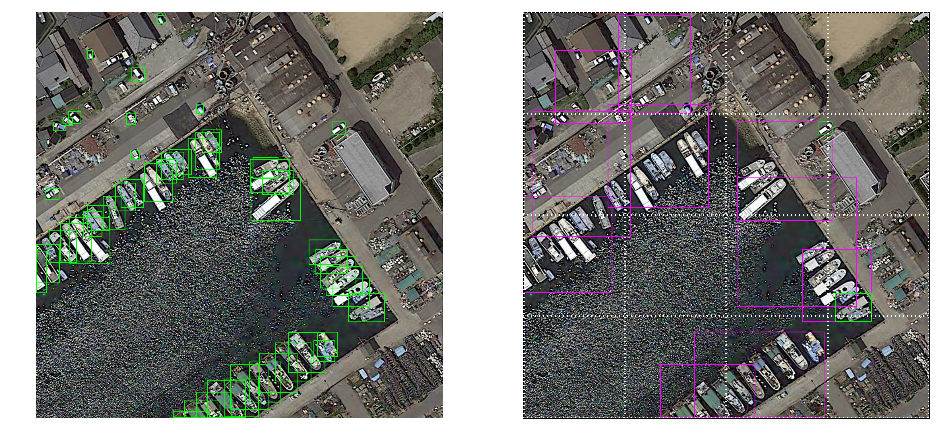

In [34]:
with tf.Graph().as_default():
    mode = 'test'
    metadata = graph_manager.load_metadata('Data/metadata_dota.txt')  
    image_size = 1024
    
    num_cells = np.array([4, 4])
    grid_offsets = graph_manager.precompute_grid_offsets(num_cells)
    
    print('\n\033[44mIn-graph inputs:\033[0m')
    inputs = tf_inputs.get_tf_dataset(metadata['%s_tfrecords' % mode],
                                      metadata['feature_keys'],
                                      metadata['%s_max_num_bbs' % mode],
                                      len(metadata['data_classes']),
                                      with_classes=True,
                                      with_groups=True,
                                      grid_offsets=grid_offsets,
                                      data_augmentation_threshold=1.,
                                      image_folder=metadata['image_folder'] % mode,
                                      batch_size=1,
                                      image_size=image_size,
                                      shuffle_buffer=1000,
                                      verbose=True)[0]
    inputs = {k: v for k, v in inputs.items() if k != 'batch_size'}

    with tf.Session() as sess:
        inputs_ = sess.run(inputs)
        # Bounding boxes (Green)
        img = np.copy(inputs_['image'][0])
        for bb in inputs_['bounding_boxes'][0]:
            viz.draw_bounding_boxes_numpy(img, bb)
        # On-the-fly group bounding boxes (Magenta)
        group_img = np.copy(inputs_['image'][0])
        group_bbs = np.reshape(inputs_['group_bounding_boxes_per_cell'][0], (-1, 4))
        group_flags = np.reshape(inputs_['group_flags'][0], (-1))
        for bb, flag in zip(group_bbs, group_flags):
            viz.draw_bounding_boxes_numpy(group_img, bb, color=(1., 0., 1.) if flag else (0., 1., 0.))
            
        # Print
        print('\n\033[44mSample:\033[0m')
        print('    im_id:', inputs_['im_id'][0])
        print('    grid size', num_cells)
        print('   ', inputs_['num_boxes'][0], 'bbs')
        print('   ', inputs_['num_group_boxes'][0], 'bbs after grouping')
        classes = np.where(inputs_['class_labels'][0] > 0)[-1]
        print('    Classes:', ', '.join(metadata['data_classes'][index] for index in classes))
        group_classes = np.where(inputs_['group_class_labels'][0] > 0)[-1]
        print('    Group classes:', ', '.join(metadata['data_classes'][index] 
                                              for index in group_classes[:inputs_['num_group_boxes'][0]]))
        # Plot
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        ax1.imshow(img)        
        ax1.set_axis_off()
        ax2.imshow(group_img)        
        ax2.set_xticks(np.linspace(0, image_size, num_cells[0] + 1))
        ax2.set_yticks(np.linspace(0, image_size, num_cells[1] + 1))        
        ax2.tick_params(labelbottom='off', labelleft='off') 
        ax2.grid(color='white', linewidth=2)
        plt.show()